In [1]:
import numpy as np, time, pickle
from scipy.sparse import load_npz
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

# Load artifacts
X_train = load_npz("X_train_tfidf.npz")
X_test  = load_npz("X_test_tfidf.npz")
y_train = np.load("y_train.npy")
y_test  = np.load("y_test.npy")

with open("tfidf_vectorizer.pkl", "rb") as f:
    tfidf = pickle.load(f)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear SVM search
lin_params = {"C":[0.1, 0.5, 1, 2, 5]}
lin = LinearSVC(random_state=42, max_iter=5000)
t0 = time.time()
lin_grid = GridSearchCV(lin, lin_params, cv=cv, scoring="f1", n_jobs=-1, verbose=0)
lin_grid.fit(X_train, y_train)
t1 = time.time()

# RBF SVM (subsampled CV for speed)
rbf_params = {"C":[0.5,1,2], "gamma":["scale", 0.1, 0.01]}
rbf = SVC(kernel="rbf", random_state=42)
# (Optional) subsample for CV speed if needed
sub = min(4000, X_train.shape[0])
rbf_grid = GridSearchCV(rbf, rbf_params, cv=3, scoring="f1", n_jobs=-1, verbose=0)
rbf_grid.fit(X_train[:sub], y_train[:sub])
t2 = time.time()

summary = pd.DataFrame([
    {"Model":"LinearSVC", "Best Params":lin_grid.best_params_, "CV F1":lin_grid.best_score_, "Train Time (s)":round(t1-t0,2)},
    {"Model":"RBF SVC  (subsample CV)", "Best Params":rbf_grid.best_params_, "CV F1":rbf_grid.best_score_, "Train Time (s)":round(t2-t1,2)},
])
summary


,Model,Best Params,CV F1,Train Time (s)
0,LinearSVC,{'C': 1},0.988373,4.87
1,RBF SVC (subsample CV),"{'C': 2, 'gamma': 'scale'}",0.981351,17.87


LinearSVC – Test Metrics
Accuracy: 0.9882  Precision: 0.9878  Recall: 0.9892  F1: 0.9885

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      3288
        Spam       0.99      0.99      0.99      3433

    accuracy                           0.99      6721
   macro avg       0.99      0.99      0.99      6721
weighted avg       0.99      0.99      0.99      6721



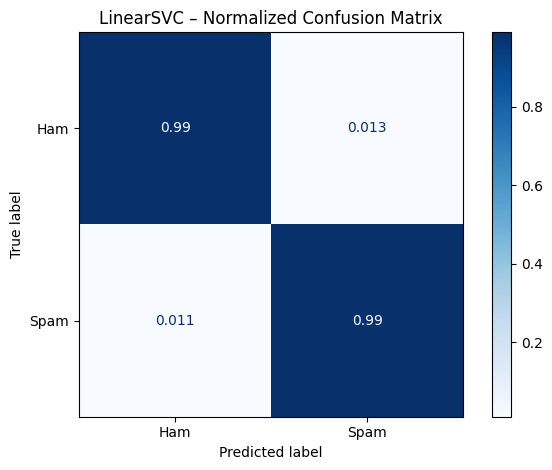

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

best_lin = lin_grid.best_estimator_
y_pred_lin = best_lin.predict(X_test)

acc = accuracy_score(y_test, y_pred_lin)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_lin, average="binary")
print("LinearSVC – Test Metrics")
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}\n")
print(classification_report(y_test, y_pred_lin, target_names=["Ham","Spam"]))

cm = confusion_matrix(y_test, y_pred_lin, normalize="true")
ConfusionMatrixDisplay(cm, display_labels=["Ham","Spam"]).plot(cmap="Blues")
plt.title("LinearSVC – Normalized Confusion Matrix")
plt.tight_layout(); plt.show()


In [ ]:
ROC & Precision-Recall curves (+ AUC/AP)

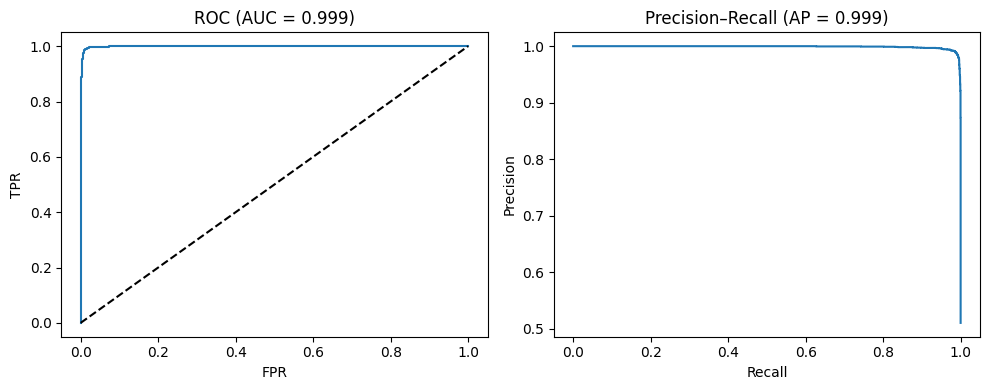

In [3]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# LinearSVC exposes decision_function (good for ranking/curves)
scores = best_lin.decision_function(X_test)

# ROC
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

# PR
prec_curve, rec_curve, _ = precision_recall_curve(y_test, scores)
ap = average_precision_score(y_test, scores)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],'k--')
ax[0].set_title(f"ROC (AUC = {roc_auc:.3f})"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")

ax[1].plot(rec_curve, prec_curve)
ax[1].set_title(f"Precision–Recall (AP = {ap:.3f})"); ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
plt.tight_layout(); plt.show()


In [ ]:
Threshold tuning (optimize F1 or desired precision/recall)

In [4]:
# Sweep thresholds over decision scores to pick an operating point
ths = np.linspace(scores.min(), scores.max(), 200)
best = {"thr":None, "f1":-1, "prec":None, "rec":None}

for thr in ths:
    y_hat = (scores >= thr).astype(int)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_hat, average="binary")
    if f1 > best["f1"]:
        best.update({"thr":thr, "f1":f1, "prec":pr, "rec":rc})

print("Best threshold by F1:")
best


Best threshold by F1:


{'thr': np.float64(0.009522739445745998),
 'f1': 0.988646288209607,
 'prec': 0.9880709921443119,
 'rec': 0.9892222545878241}

In [ ]:
Calibration check

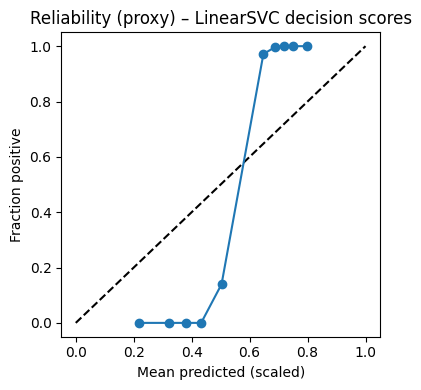

In [5]:
from sklearn.calibration import calibration_curve

prob_like = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)  # min-max to [0,1] proxy

frac_pos, mean_pred = calibration_curve(y_test, prob_like, n_bins=10, strategy="quantile")
plt.figure(figsize=(4,4))
plt.plot([0,1],[0,1],'k--')
plt.plot(mean_pred, frac_pos, marker='o')
plt.title("Reliability (proxy) – LinearSVC decision scores")
plt.xlabel("Mean predicted (scaled)"); plt.ylabel("Fraction positive")
plt.tight_layout(); plt.show()


In [ ]:
Error analysis – show hardest FPs/FNs

In [6]:
# Get indices sorted by margin (confidence)
idx = np.argsort(scores)  # low → very negative (ham); high → very positive (spam)

# Load raw text to inspect
import pandas as pd
df = pd.read_csv("enron_spam_data.csv")
df["text"] = df["Subject"].fillna("") + " " + df["Message"].fillna("")

# Map test indices back (we need the same split order; if not retained, show only a sample)
# If you used train_test_split earlier in the same session, keep the X_test indexes:
# For this demo, we just show a few examples by masking predictions:
mask_fp = (y_test == 0) & (y_pred_lin == 1)
mask_fn = (y_test == 1) & (y_pred_lin == 0)

print("\nTop 5 False Positives (predicted spam, actually ham):")
fp_idx = np.where(mask_fp)[0][:5]
for i in fp_idx:
    print(f"\n--- FP #{i} ---\nText snippet:\n", df.loc[i, "text"][:400])

print("\nTop 5 False Negatives (predicted ham, actually spam):")
fn_idx = np.where(mask_fn)[0][:5]
for i in fn_idx:
    print(f"\n--- FN #{i} ---\nText snippet:\n", df.loc[i, "text"][:400])



Top 5 False Positives (predicted spam, actually ham):

--- FP #526 ---
Text snippet:
 fyi daren ,
hey , sorry about not calling you last thur & fri - i was out sick . i think
that were going to have to play this assistance thing on a day to day basis .
i know i will be catching up for missing those days & i need to get some
things in order this week for the new guy that starts next week . so i ' ll
just have to call you when i can spare the time . sorry for any inconvenience
this m

--- FP #561 ---
Text snippet:
 re : jan & feb midcon invoices daren ,
do you have any information on these deals ? we cannot collect the cash from
midcon if we can ' t prove to them the
deals are valid .
thanks ,
kris
tina valadez
03 / 29 / 2000 09 : 19 am
to : kristen j hanson / hou / ect @ ect
cc :
subject : jan & feb midcon invoices
- - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 03 / 29 

--- FP #666 ---
Text snippet:
 well head this must be change day , shoreline w

In [ ]:
Interpretability – top terms per class

In [7]:
# Only valid for linear models
feature_names = np.array(tfidf.get_feature_names_out())
coef = best_lin.coef_.ravel()

top_spam_idx = np.argsort(coef)[-25:][::-1]
top_ham_idx  = np.argsort(coef)[:25]

spam_terms = pd.DataFrame({"term":feature_names[top_spam_idx], "weight":coef[top_spam_idx]})
ham_terms  = pd.DataFrame({"term":feature_names[top_ham_idx],  "weight":coef[top_ham_idx]})

print("Top spam-indicative terms:")
display(spam_terms)

print("Top ham-indicative terms:")
display(ham_terms)


Top spam-indicative terms:


,term,weight
0,remove,2.356702
1,http,1.808222
2,software,1.762590
3,php,1.697192
4,med,1.535184
5,removed,1.460210
6,investment,1.439658
7,found,1.371072
8,paliourg,1.365725
9,sex,1.325246


Top ham-indicative terms:


,term,weight
0,enron,-5.984061
1,louise,-3.704800
2,vince,-3.477921
3,daren,-2.493747
4,attached,-2.434682
5,employee,-2.388017
6,doc,-2.376508
7,let know,-2.363069
8,enron com,-2.276121
9,houston,-2.238087


In [ ]:
Ablations: (a) unigram vs bigram; (b) C-sweep plot

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Reload raw cleaned text if needed (or store earlier during preprocessing)
raw = pd.read_csv("enron_spam_data.csv")
raw["text"] = raw["Subject"].fillna("") + " " + raw["Message"].fillna("")
y = raw["Spam/Ham"].map({"ham":0,"spam":1}).astype(int)
X_tr, X_te, y_tr, y_te = train_test_split(raw["text"], y, test_size=0.2, random_state=42, stratify=y)

def run_variant(ngram):
    vec = TfidfVectorizer(max_features=5000, ngram_range=ngram, stop_words="english")
    Xt = vec.fit_transform(X_tr)
    Xv = vec.transform(X_te)
    m = LinearSVC(random_state=42, C=1.0, max_iter=5000)
    m.fit(Xt, y_tr)
    pred = m.predict(Xv)
    return accuracy_score(y_te, pred), f1_score(y_te, pred)

acc1, f11 = run_variant((1,1))
acc2, f12 = run_variant((1,2))

print(f"Unigram only:    Acc={acc1:.4f}, F1={f11:.4f}")
print(f"Uni+Bigram:      Acc={acc2:.4f}, F1={f12:.4f}")


Unigram only:    Acc=0.9913, F1=0.9914
Uni+Bigram:      Acc=0.9910, F1=0.9912


In [9]:
def predict_email(subject, message, model=best_lin, vectorizer=tfidf, thr=None):
    text = f"{subject or ''} {message or ''}"
    X = vectorizer.transform([text])
    score = model.decision_function(X)[0]
    pred = int(score >= (thr if thr is not None else 0.0))
    label = "spam" if pred==1 else "ham"
    return {"label": label, "score": float(score), "threshold": thr}

# Example:
predict_email("FREE OFFER just for you", "Click the link now to claim your prize")


{'label': 'spam', 'score': 2.1018031027568496, 'threshold': None}